In [7]:
using CSV, DataFrames, TimeSeries, DataStructures, Clustering
using GraphPlot, Graphs, URIs
using StatsBase: maximum, minimum, median, mean, countmap
import PyPlot as plt
import PlotlyJS
include("../influencecascade_platform.jl")
include("../entropy.jl")
include("../tool_helper.jl")
include("../visualizations.jl");

LoadError: LoadError: syntax: incomplete: premature end of input
in expression starting at /Users/cyrilvallez/Desktop/Thesis/Julia/visualizations.jl:133

## Load the data and format it

In [2]:
datafolder = "../../Data/Twitter/"
datafile = datafolder * "all_links_processed.json"

#=
data = CSV.read(datafiles[1], DataFrame, header=1, types=String)

#new_row = DataFrame(id = "0006", author_id = "6", username = "?Cyril06", created_at = "2021-10-31T00:09:04.000Z", lang = "en", text = "test climate change", original_text = "test climate change",
#    hashtags = missing, category = "['tweeted']", URLs = "['https://www.cnn.com/test']", domain = "['cnn']", domain_suffix = "['com']", country = missing, country_code = missing, sentiment = "neutral")
#append!(data, new_row);

function str_to_vec(string)
    if ismissing(string)
        return missing
    end
    # remove `[]` characters at beginning and end, and split based on commas following a quote char
    list = split(string[2:end-1], "', ")
    res = []
    for str in list
        if first(str) == '\'' && last(str) == '\''
            push!(res, String(collect(str)[2:end-1]))
        elseif first(str) == '\''
            push!(res, String(collect(str)[2:end]))
        elseif last(str) == '\''
            push!(res, String(collect(str)[1:end-1]))
        end
    end
    return res
end

data."hashtags" = data."hashtags" .|> str_to_vec
data."category" = data."category" .|> str_to_vec
data."URLs" = data."URLs" .|> str_to_vec
data."domain" = data."domain" .|> str_to_vec
data."domain_suffix" = data."domain_suffix" .|> str_to_vec

=#

data = load_json(datafile)
data = data[.~ismissing.(data."urls"), :]

#clean_dates = x -> floor(DateTime(split(x, '.')[1], "yyyy-mm-ddTHH:MM:SS"), Dates.Minute(5))
clean_dates = x -> floor(DateTime(split(x, '.')[1], "yyyy-mm-ddTHH:MM:SS"), Dates.Hour(5));
data.time = clean_dates.(data."created_at");

## Define the partition, actors and actions

In [3]:
part_fun = sentiment
actor_fun = follower_count
action_fun = trust_popularity_score_v2

cuttoff = 0.5
et = "Any Edge"
part = "neutral"

df = data |> part_fun |> action_fun |> actor_fun |> x->sort(x,:time);

## Compute influence graph

In [6]:
tsg = TimeSeriesGenerator(:actor, :action, :partition)
time_series = observe(df, tsg)

ig = InfluenceGrapher(unique(df[!, tsg.action_col]))
influence_graph = observe(time_series, ig);


## Compte influence cascade and plot influence graph

In [ ]:
begin
	function make_simplifier(edge_type)
		if edge_type=="Any Edge"
			return x->(maximum(x)>cuttoff)
		else
			idx = findfirst(x->(x==et), edgeTypes)
			return x->(x[idx]>cuttoff)
		end
	end
	s = make_simplifier(et)

	icg = InfluenceCascadeGenerator(cuttoff)
	influence_cascades = observe.(influence_graph, Ref(icg))
	all_ics = vcat(influence_cascades...)

	partitions = unique(df[!,tsg.part_col])
	i = (1:length(partitions))[findfirst(x->x==part, partitions)]
	xs, ys, influencers = influence_layout(influence_graph[i]; simplifier=s)
	g = print_graph(influence_graph[i]; simplifier=s)

	# In this case we plot the graph on a world map
	if actor_fun == country
		PlotlyJS.plot(map_plot(df)...)
	# In this case we plot a simple graph of the actors
	else
		gplot(g, xs, ys, nodelabel=unique(df.actor))
	end
end

In [ ]:
infl = unique(df.actor)[influencers]
influencer_node1 = infl[1]
influencer_node2 = infl[1]

PlotlyJS.plot(plot_cascade_sankey(
	influence_cascades[findfirst(x->x==part,unique(df[!, tsg.part_col]))][findfirst(x->x==influencer_node1, unique(df[!, tsg.actor_col])[influencers])],
	unique(df[!, tsg.action_col]))...)

In [ ]:
PlotlyJS.plot(plot_cascade_sankey(
	influence_cascades[findfirst(x->x==part,unique(df[!, tsg.part_col]))][findfirst(x->x==influencer_node2, unique(df[!, tsg.actor_col])[influencers])],
	unique(df[!, tsg.action_col]))...)

In [ ]:
plot_actors_per_level(influence_cascades, unique(df[!,:partition]))

In [ ]:
actor_wordcloud(df, Nactor=300)

PyPlot.Figure(PyObject <Figure size 640x480 with 1 Axes>)

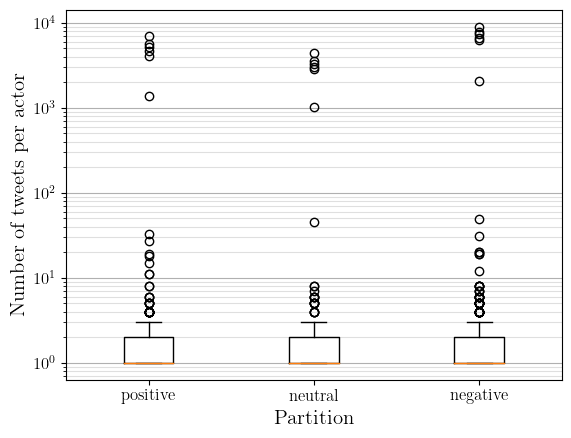

In [28]:
include("../visualizations.jl")
show(actor_frequency(df, save=true, filename="test2.pdf"))

PyPlot.Figure(PyObject <Figure size 640x480 with 1 Axes>)

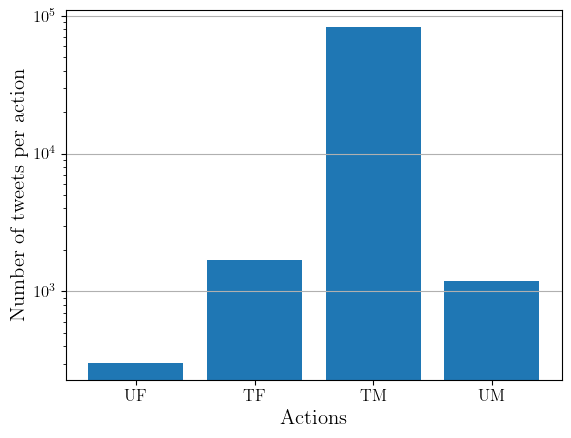

In [35]:
include("../visualizations.jl")
show(action_frequency(df, split_by_partition = false))

PyPlot.Figure(PyObject <Figure size 800x800 with 3 Axes>)

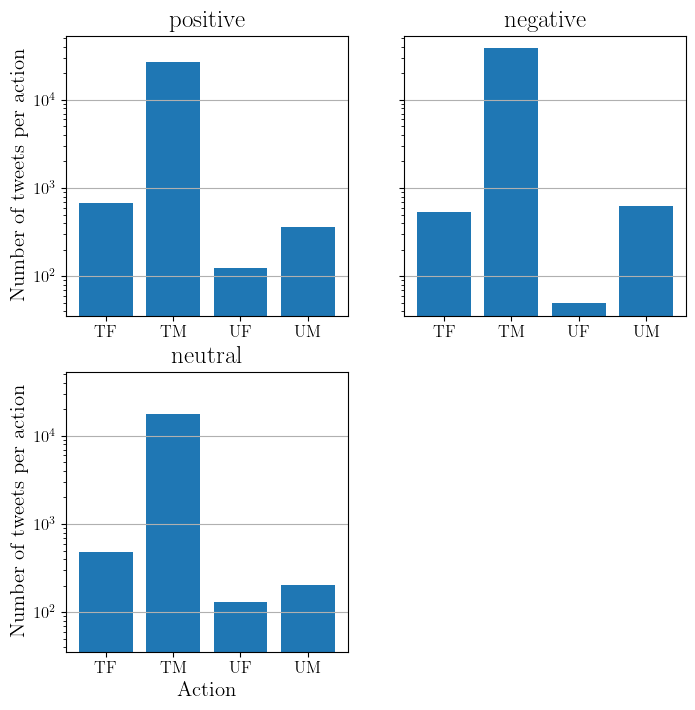

In [50]:
include("../visualizations.jl")
show(action_frequency(df, split_by_partition = true))

In [39]:
countmaps = combine(groupby(df, "partition"), "action" => countmap => "countmap")
partitions = countmaps."partition"
counts = collect.(values.(countmaps."countmap"))
actions = collect.(keys.(countmaps."countmap"))
# Sort to ensure that we get the same ordering of the actions each time



3-element Vector{Vector{String}}:
 ["UF", "TF", "TM", "UM"]
 ["UF", "TF", "TM", "UM"]
 ["UF", "TF", "TM", "UM"]

In [40]:
actions

3-element Vector{Vector{String}}:
 ["UF", "TF", "TM", "UM"]
 ["UF", "TF", "TM", "UM"]
 ["UF", "TF", "TM", "UM"]

In [41]:
counts

3-element Vector{Vector{Int64}}:
 [125, 679, 27191, 364]
 [129, 476, 17602, 203]
 [50, 540, 38464, 618]

In [42]:
for i in 1:length(counts)
    sorting = sortperm(actions[i])
    counts[i] = counts[i][sorting]
    actions[i] = actions[i][sorting]
end

In [43]:
actions

3-element Vector{Vector{String}}:
 ["TF", "TM", "UF", "UM"]
 ["TF", "TM", "UF", "UM"]
 ["TF", "TM", "UF", "UM"]

In [44]:
counts

3-element Vector{Vector{Int64}}:
 [679, 27191, 125, 364]
 [476, 17602, 129, 203]
 [540, 38464, 50, 618]